In [12]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 
import random

## Utilities

In [13]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
      
    temp = np.sort(rank)
    temp = np.concatenate((temp[::2], temp[1::2][::-1]))
    rank = random.sample(range(1, len(temp)+1),len(temp))
    
    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval


def cat_to_names(df,references):
    ref = df.columns[df.columns.isin(references.keys())].to_list()
    temp_df = df.copy()
    for key in ref:
        vals = references[key]
        for label_key in vals.keys():
            temp_df[key] = temp_df[key].replace(vals[label_key],label_key)
    return temp_df

In [20]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
new_df = pd.read_csv('newdata.csv')

carmax_df['job_assign'] = new_df['job_assign']
cluster_df = carmax_df.copy().drop(['customer_age','customer_previous_purchase','customer_distance_to_dealer',
                             'post_purchase_satisfaction','vehicle_warranty_used','subsequent_purchases',
                             'purchase_price_UB'], axis=1)

In [21]:
## references of transformation for later 
references = {}

# transform to numerical values 
for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

## Time to Cluster - Gonna use k-means initially 

In general, we can cluster observations on the basis of the features in order to identify subgroups among the observations, or we can cluster fea- tures on the basis of the observations in order to discover subgroups among the features. In what follows, for simplicity we will discuss clustering obser- vations on the basis of the features, though the converse can be performed by simply transposing the data matrix.

### Convert the Categorical Variables to Numbers

### Normalize the Data

In [22]:
from sklearn.preprocessing import StandardScaler

X = cluster_df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.9618901 , -1.37020869,  0.99205841, ..., -0.70369102,
        -0.32111555,  1.40821245],
       [ 1.63032692, -1.3594839 , -1.01442395, ..., -0.12775565,
        -0.32111555, -0.87296291],
       [-0.87548286, -1.01092854,  0.18946547, ..., -0.70369102,
        -2.21095458, -0.81077879],
       ...,
       [-0.70266839, -0.87686879,  0.99205841, ...,  0.44817972,
         0.30883079,  1.04492628],
       [-0.61626116,  1.18765142, -2.61960984, ...,  1.60005047,
         0.93877713, -0.64713637],
       [ 0.24781118, -1.32194717,  0.99205841, ..., -0.70369102,
        -0.32111555,  1.34930118]])

### Cluster the Data into 5 distinct Clusters

In [23]:
num_clusters = 10

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan")
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 2 6 ... 1 4 1]


In [24]:
k_means.inertia_/cluster_df.shape[0]

7.7896229741181715

In [10]:
cluster_df["Labels"] = labels
cluster_df.Labels.unique()

array([2, 0, 3, 1, 4])

### Now that the data has been clustered map back to names

In [11]:
def cat_to_names(df,references):
    temp_df = df.copy()
    for key in references.keys():
        vals = references[key]
        for label_key in vals.keys():
            temp_df[key] = temp_df[key].replace(vals[label_key],label_key)
    return temp_df

In [12]:
cluster_with_names = cat_to_names(cluster_df,references)

In [13]:
cluster_with_names.groupby(['Labels']).agg(pd.Series.mode)

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
Labels,,,,,,,,,,,,,,,
0,TOYOTA,ALTIMA,2010,15001.0,20000.0,0,0,?,M,0,5.0,0,0,Forties,sedan
1,NISSAN,ALTIMA,2010,10001.0,15000.0,0,1,20001 - 40000,M,0,6.0,1,0,Thirties,sedan
2,NISSAN,ALTIMA,2012,15001.0,20000.0,0,1,20001 - 40000,M,0,5.0,0,0,Twenties,sedan
3,MERCEDES-BENZ,F150,2011,25001.0,30000.0,1,1,40001 - 60000,M,0,5.0,0,0,Forties,suv
4,CHEVROLET,COOPER,2012,15001.0,20000.0,1,1,40001 - 60000,M,0,2396.0,0,0,Twenties,sedan


inertia_float
 - Sum of squared distances of samples to their closest cluster center.

When using an optimization algorithm like gradient descent, there is an error that it tries to minimize. While k-means does not explicitly try to minimize some error, we still have a way to measure error. It's called inertia. Inertia is the sum of square distances of samples to their closest cluster center. The smaller the inertia, the better.

In [14]:
counts_of_puchase_models = cluster_with_names.groupby(['Labels','purchase_make']).count().reset_index().rename(columns={"purchase_vehicle_year":"count"})
counts_of_puchase_models

,Labels,purchase_make,purchase_model,count,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
0,0,ACURA,827,827,827,827,827,827,827,827,827,803,827,827,827,827
1,0,AUDI,437,437,437,437,437,437,437,437,437,424,437,437,437,437
2,0,BENTLEY,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,0,BMW,1512,1512,1512,1512,1512,1512,1512,1512,1512,1479,1512,1512,1512,1512
4,0,BUICK,614,614,614,614,614,614,614,614,614,596,614,614,614,614
5,0,CADILLAC,652,652,652,652,652,652,652,652,652,641,652,652,652,652
6,0,CHEVROLET,5976,5976,5976,5976,5976,5976,5976,5976,5976,5787,5976,5976,5976,5976
7,0,CHRYSLER,1809,1809,1809,1809,1809,1809,1809,1809,1809,1759,1809,1809,1809,1809
8,0,DODGE,3469,3469,3469,3469,3469,3469,3469,3469,3469,3367,3469,3469,3469,3469
9,0,FIAT,169,169,169,169,169,169,169,169,169,162,169,169,169,169


In [15]:
var1 = 'purchase_make'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1]).count().reset_index().rename(columns={'trade_in':"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    top10_dfs.append(temp_df.sort_values(by='count',ascending=False).head(2))


top10_dfs = pd.concat(top10_dfs)
top10_dfs

,Labels,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
39,0,TOYOTA,9000,9000,9000,9000,9000,9000,9000,9000,9000,8764,9000,9000,9000,9000
10,0,FORD,8799,8799,8799,8799,8799,8799,8799,8799,8799,8512,8799,8799,8799,8799
69,1,NISSAN,7429,7429,7429,7429,7429,7429,7429,7429,7429,7336,7429,7429,7429,7429
47,1,CHEVROLET,7317,7317,7317,7317,7317,7317,7317,7317,7317,7213,7317,7317,7317,7317
108,2,NISSAN,21670,21670,21670,21670,21670,21670,21670,21670,21670,21377,21670,21670,21670,21670
117,2,TOYOTA,19733,19733,19733,19733,19733,19733,19733,19733,19733,19486,19733,19733,19733,19733
143,3,MERCEDES-BENZ,6308,6308,6308,6308,6308,6308,6308,6308,6308,6220,6308,6308,6308,6308
129,3,FORD,6165,6165,6165,6165,6165,6165,6165,6165,6165,6060,6165,6165,6165,6165
162,4,CHEVROLET,32,32,32,32,32,32,32,32,32,32,32,32,32,32
186,4,TOYOTA,31,31,31,31,31,31,31,31,31,31,31,31,31,31


https://kenzotakahashi.github.io/k-means-clustering-from-scratch-in-python.html#:~:text=It's%20called%20inertia.,smaller%20the%20inertia%2C%20the%20better

In [84]:
var1 = 'customer_gender'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1]).count().reset_index().rename(columns={'trade_in':"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    top10_dfs.append(temp_df.sort_values(by='count',ascending=False).head(3))


top10_dfs = pd.concat(top10_dfs)
top10_dfs

,Labels,customer_gender,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
1,0,M,36723,36723,36723,36723,36723,36723,36723,36723,36723,35681,36723,36723,36723,36723
0,0,F,24068,24068,24068,24068,24068,24068,24068,24068,24068,23468,24068,24068,24068,24068
2,0,U,6346,6346,6346,6346,6346,6346,6346,6346,6346,6158,6346,6346,6346,6346
4,1,M,31464,31464,31464,31463,31463,31464,31464,31464,31464,31041,31464,31464,31464,31464
3,1,F,26554,26554,26554,26554,26554,26554,26554,26554,26554,26213,26554,26554,26554,26554
5,1,U,7214,7214,7214,7214,7214,7214,7214,7214,7214,7095,7214,7214,7214,7214
7,2,M,187,187,187,187,187,187,187,187,187,187,187,187,187,187
6,2,F,106,106,106,106,106,106,106,106,106,106,106,106,106,106
8,2,U,16,16,16,16,16,16,16,16,16,16,16,16,16,16
10,3,M,34855,34855,34855,34855,34855,34855,34855,34855,34855,34301,34855,34855,34855,34855


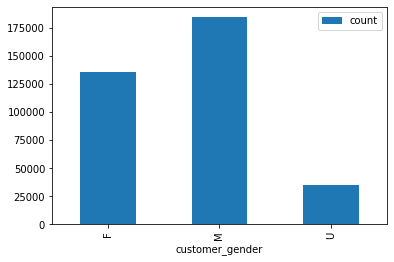

In [90]:
cluster_with_names.groupby('customer_gender').count().reset_index().rename(columns={'purchase_make':'count'}).plot.bar(x='customer_gender',y='count')

In [95]:
var1 = 'customer_gender'
var2 = 'purchase_make'
var3 = 'AgeBin'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1,var2,var3]).count().reset_index().rename(columns={'trade_in':"count"})
counts_of_puchase_models

,Labels,customer_gender,purchase_make,AgeBin,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,purchase_class
0,0,F,ACURA,Eighties,1,1,1,1,1,1,1,1,1,1,1,1
1,0,F,ACURA,Fifties,46,46,46,46,46,46,46,46,46,46,46,46
2,0,F,ACURA,Forties,63,63,63,63,63,63,63,63,62,63,63,63
3,0,F,ACURA,HundredPlus,1,1,1,1,1,1,1,1,1,1,1,1
4,0,F,ACURA,Seventies,7,7,7,7,7,7,7,7,6,7,7,7
5,0,F,ACURA,Sixties,23,23,23,23,23,23,23,23,21,23,23,23
6,0,F,ACURA,Thirties,63,63,63,63,63,63,63,63,58,63,63,63
7,0,F,ACURA,Twenties,57,57,57,57,57,57,57,57,57,57,57,57
8,0,F,ACURA,UnderTwenty,2,2,2,2,2,2,2,2,2,2,2,2
9,0,F,ACURA,Unknown,4,4,4,4,4,4,4,4,1,4,4,4


In [91]:
var1 = 'customer_gender'
var2 = 'purchase_make'
var3 = 'AgeBin'
counts_of_puchase_models = cluster_with_names.groupby(['Labels',var1,var2,var3]).count().reset_index().rename(columns={'trade_in':"count"})

top10_dfs = []
for i in counts_of_puchase_models['Labels'].unique():
    temp_df=counts_of_puchase_models[counts_of_puchase_models.Labels==i]
    top10_dfs.append(temp_df.sort_values(by='count',ascending=False).head(3))


top10_dfs = pd.concat(top10_dfs)
top10_dfs

,Labels,customer_gender,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,count,vehicle_financing,customer_income,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class
1,0,M,36723,36723,36723,36723,36723,36723,36723,36723,36723,35681,36723,36723,36723,36723
0,0,F,24068,24068,24068,24068,24068,24068,24068,24068,24068,23468,24068,24068,24068,24068
2,0,U,6346,6346,6346,6346,6346,6346,6346,6346,6346,6158,6346,6346,6346,6346
4,1,M,31464,31464,31464,31463,31463,31464,31464,31464,31464,31041,31464,31464,31464,31464
3,1,F,26554,26554,26554,26554,26554,26554,26554,26554,26554,26213,26554,26554,26554,26554
5,1,U,7214,7214,7214,7214,7214,7214,7214,7214,7214,7095,7214,7214,7214,7214
7,2,M,187,187,187,187,187,187,187,187,187,187,187,187,187,187
6,2,F,106,106,106,106,106,106,106,106,106,106,106,106,106,106
8,2,U,16,16,16,16,16,16,16,16,16,16,16,16,16,16
10,3,M,34855,34855,34855,34855,34855,34855,34855,34855,34855,34301,34855,34855,34855,34855


## Let's Look at Correlations within Clusters

#### Cluster 1

In [34]:
print("Print Size of Cluster:",cluster_with_names[cluster_with_names.Labels==0].shape)

Print Size of Cluster: (67165, 16)


In [25]:
cluster_with_names[cluster_with_names.Labels==0].drop(columns="Labels").corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
purchase_vehicle_year,1.000000,0.357895,0.357895,0.074258,NaN,-0.017627,0.003495,-0.132590,-0.015312
purchase_price_LB,0.357895,1.000000,1.000000,0.126367,NaN,0.002974,0.021609,-0.007477,-0.016027
purchase_price_UB,0.357895,1.000000,1.000000,0.126367,NaN,0.002974,0.021609,-0.007477,-0.016027
trade_in,0.074258,0.126367,0.126367,1.000000,NaN,0.107270,-0.031587,0.025909,0.019871
vehicle_financing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_previous_purchase,-0.017627,0.002974,0.002974,0.107270,NaN,1.000000,-0.040221,-0.004472,0.043512
customer_distance_to_dealer,0.003495,0.021609,0.021609,-0.031587,NaN,-0.040221,1.000000,-0.039851,-0.007059
vehicle_warranty_used,-0.132590,-0.007477,-0.007477,0.025909,NaN,-0.004472,-0.039851,1.000000,0.008382
subsequent_purchases,-0.015312,-0.016027,-0.016027,0.019871,NaN,0.043512,-0.007059,0.008382,1.000000


Interesting from here we see vehicle financing only takes one value here. 

In [26]:
cluster_with_names[cluster_with_names.Labels==0]['vehicle_financing'].unique()[0]

0

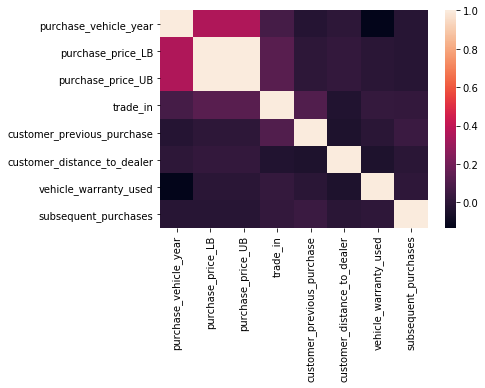

In [28]:
ax = sns.heatmap(cluster_with_names[cluster_with_names.Labels==0].drop(columns=["vehicle_financing","Labels"]).corr())

#### Cluster 2

In [35]:
print("Print Size of Cluster:",cluster_with_names[cluster_with_names.Labels==1].shape)

Print Size of Cluster: (65158, 16)


In [30]:
cluster_with_names[cluster_with_names.Labels==1].drop(columns="Labels").corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
purchase_vehicle_year,1.000000,0.330877,0.330877,0.055398,0.166183,0.013549,-0.010516,0.115260,-0.004536
purchase_price_LB,0.330877,1.000000,1.000000,0.092682,0.095475,0.057934,0.009768,0.008300,0.010241
purchase_price_UB,0.330877,1.000000,1.000000,0.092682,0.095475,0.057934,0.009768,0.008300,0.010241
trade_in,0.055398,0.092682,0.092682,1.000000,-0.025421,0.146265,-0.019599,-0.002760,0.032120
vehicle_financing,0.166183,0.095475,0.095475,-0.025421,1.000000,-0.022401,-0.003639,0.059994,-0.008083
customer_previous_purchase,0.013549,0.057934,0.057934,0.146265,-0.022401,1.000000,-0.010868,-0.002581,0.023379
customer_distance_to_dealer,-0.010516,0.009768,0.009768,-0.019599,-0.003639,-0.010868,1.000000,-0.000651,0.000676
vehicle_warranty_used,0.115260,0.008300,0.008300,-0.002760,0.059994,-0.002581,-0.000651,1.000000,-0.006353
subsequent_purchases,-0.004536,0.010241,0.010241,0.032120,-0.008083,0.023379,0.000676,-0.006353,1.000000


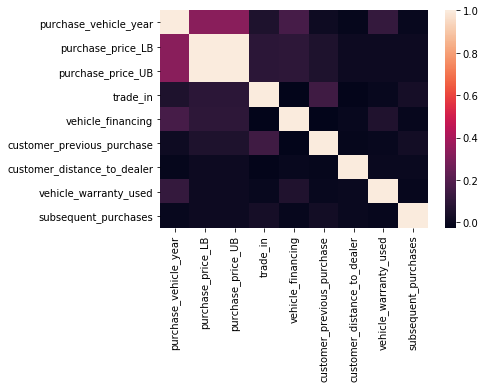

In [36]:
ax = sns.heatmap(cluster_with_names[cluster_with_names.Labels==1].drop(columns="Labels").corr())

#### Cluster 3

In [38]:
print("Print Size of Cluster:",cluster_with_names[cluster_with_names.Labels==2].shape)

Print Size of Cluster: (165842, 16)


In [39]:
cluster_with_names[cluster_with_names.Labels==2].drop(columns="Labels").corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
purchase_vehicle_year,1.000000,0.320649,0.320649,0.048818,NaN,0.005086,-0.009649,NaN,0.004008
purchase_price_LB,0.320649,1.000000,1.000000,0.080019,NaN,0.002823,0.017594,NaN,-0.002531
purchase_price_UB,0.320649,1.000000,1.000000,0.080019,NaN,0.002823,0.017594,NaN,-0.002531
trade_in,0.048818,0.080019,0.080019,1.000000,NaN,0.100703,-0.030801,NaN,0.011399
vehicle_financing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_previous_purchase,0.005086,0.002823,0.002823,0.100703,NaN,1.000000,-0.020674,NaN,0.007404
customer_distance_to_dealer,-0.009649,0.017594,0.017594,-0.030801,NaN,-0.020674,1.000000,NaN,0.001167
vehicle_warranty_used,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subsequent_purchases,0.004008,-0.002531,-0.002531,0.011399,NaN,0.007404,0.001167,NaN,1.000000


### This cluster is for financing and is the largest cluster. It also has no vehicle warranty used

In [41]:
cluster_with_names[cluster_with_names.Labels==2]['vehicle_financing'].unique()[0]

1

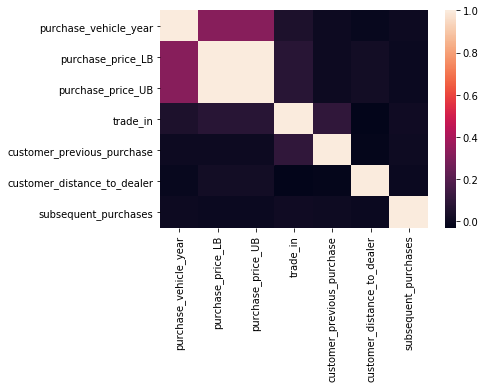

In [43]:
ax = sns.heatmap(cluster_with_names[cluster_with_names.Labels==2].drop(columns=["vehicle_financing","vehicle_warranty_used","Labels"]).corr())

In [44]:
cluster_with_names[cluster_with_names.Labels==2].drop(columns=["vehicle_financing","vehicle_warranty_used","Labels"]).corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,customer_previous_purchase,customer_distance_to_dealer,subsequent_purchases
purchase_vehicle_year,1.000000,0.320649,0.320649,0.048818,0.005086,-0.009649,0.004008
purchase_price_LB,0.320649,1.000000,1.000000,0.080019,0.002823,0.017594,-0.002531
purchase_price_UB,0.320649,1.000000,1.000000,0.080019,0.002823,0.017594,-0.002531
trade_in,0.048818,0.080019,0.080019,1.000000,0.100703,-0.030801,0.011399
customer_previous_purchase,0.005086,0.002823,0.002823,0.100703,1.000000,-0.020674,0.007404
customer_distance_to_dealer,-0.009649,0.017594,0.017594,-0.030801,-0.020674,1.000000,0.001167
subsequent_purchases,0.004008,-0.002531,-0.002531,0.011399,0.007404,0.001167,1.000000


#### Cluster 4

In [51]:
print("Print Size of Cluster:",cluster_with_names[cluster_with_names.Labels==3].shape)

Print Size of Cluster: (57400, 16)


In [52]:
cluster_with_names[cluster_with_names.Labels==3].drop(columns="Labels").corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
purchase_vehicle_year,1.000000,0.026501,0.026501,0.043524,-0.052421,-0.004466,-0.001962,-0.150449,-0.005067
purchase_price_LB,0.026501,1.000000,1.000000,-0.073866,-0.253430,-0.158780,-0.006872,0.109305,0.004608
purchase_price_UB,0.026501,1.000000,1.000000,-0.073866,-0.253430,-0.158780,-0.006872,0.109305,0.004608
trade_in,0.043524,-0.073866,-0.073866,1.000000,0.003433,0.174561,-0.041423,0.031400,0.022818
vehicle_financing,-0.052421,-0.253430,-0.253430,0.003433,1.000000,0.020961,-0.010108,-0.039626,-0.006215
customer_previous_purchase,-0.004466,-0.158780,-0.158780,0.174561,0.020961,1.000000,-0.026130,-0.000272,0.026915
customer_distance_to_dealer,-0.001962,-0.006872,-0.006872,-0.041423,-0.010108,-0.026130,1.000000,-0.042805,-0.004850
vehicle_warranty_used,-0.150449,0.109305,0.109305,0.031400,-0.039626,-0.000272,-0.042805,1.000000,0.020200
subsequent_purchases,-0.005067,0.004608,0.004608,0.022818,-0.006215,0.026915,-0.004850,0.020200,1.000000


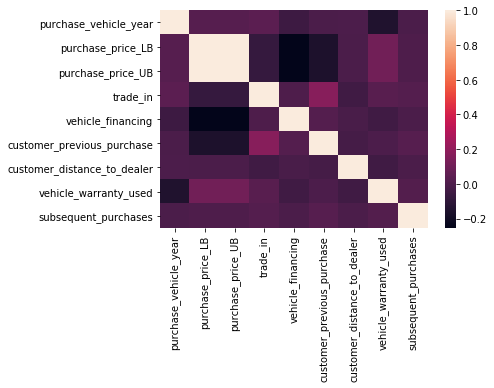

In [54]:
ax = sns.heatmap(cluster_with_names[cluster_with_names.Labels==3].drop(columns="Labels").corr())

#### Cluster 5

In [45]:
print("Print Size of Cluster:",cluster_with_names[cluster_with_names.Labels==4].shape)

Print Size of Cluster: (309, 16)


In [47]:
cluster_with_names[cluster_with_names.Labels==4].drop(columns="Labels").corr()

,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases
purchase_vehicle_year,1.000000,0.286409,0.286409,-0.014358,-0.042106,-0.065076,0.086602,-0.291321,-0.089057
purchase_price_LB,0.286409,1.000000,1.000000,0.142986,-0.156990,0.007390,-0.042151,0.017028,-0.086340
purchase_price_UB,0.286409,1.000000,1.000000,0.142986,-0.156990,0.007390,-0.042151,0.017028,-0.086340
trade_in,-0.014358,0.142986,0.142986,1.000000,0.052842,0.163133,-0.063007,0.031206,-0.005107
vehicle_financing,-0.042106,-0.156990,-0.156990,0.052842,1.000000,0.035581,0.004985,0.060971,0.070383
customer_previous_purchase,-0.065076,0.007390,0.007390,0.163133,0.035581,1.000000,-0.012699,0.082806,0.093773
customer_distance_to_dealer,0.086602,-0.042151,-0.042151,-0.063007,0.004985,-0.012699,1.000000,0.004436,0.008424
vehicle_warranty_used,-0.291321,0.017028,0.017028,0.031206,0.060971,0.082806,0.004436,1.000000,0.163968
subsequent_purchases,-0.089057,-0.086340,-0.086340,-0.005107,0.070383,0.093773,0.008424,0.163968,1.000000


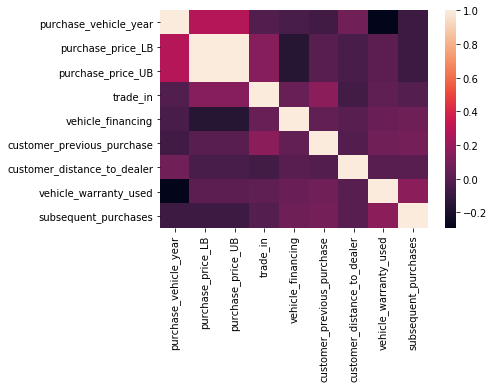

In [48]:
ax = sns.heatmap(cluster_with_names[cluster_with_names.Labels==4].drop(columns="Labels").corr())

This is the smallest cluster but has be strongest correlations amongst variables